In [123]:
import sys
import os
import glob
sys.path.append('../..')

from model import processing

prefix = 'DOTBUSD'
tick = '1s'

path = 'input/'
extension = 'csv'
os.chdir(path)
result = glob.glob(prefix + '-' + tick + '-' + '*.{}'.format(extension))
os.chdir('..')

# input_filename = 'input/DOTBUSD-1s-2022-11-22.csv'
print(result)
# input_filename = 'input/test.csv'
output_filename = 'output/' + prefix + "-" + tick + "-output.csv"

price_data = processing.import_binance_prices(path, result)[::12]
# price_data2 = processing.de_freq(price_data, 180)
# price_list = [None]*len(price_data)
final_price = price_data[-1]
price_data.extend([final_price] * 100)
price_list = [{'DOT':data.price} for data in price_data]
print(price_list[0:10])

# prefix = 'BTCBUSD'
# tick = '1s'

# path = 'input/'
# extension = 'csv'
# os.chdir(path)
# result = glob.glob(prefix + '-' + tick + '-' + '*.{}'.format(extension))
# os.chdir('..')

# # input_filename = 'input/DOTBUSD-1s-2022-11-22.csv'
# print(result)
# # input_filename = 'input/test.csv'
# output_filename = 'output/' + prefix + "-" + tick + "-output.csv"

# price_data = processing.import_binance_prices(path, result)[::1200]
# # price_data2 = processing.de_freq(price_data, 180)
# # price_list = [None]*len(price_data)
# final_price = price_data[-1]
# price_data.extend([final_price] * 100)
# price_list = [{'DOT':data.price} for data in price_data]
# print(price_list[0:10])

['DOTBUSD-1s-2022-11-21.csv', 'DOTBUSD-1s-2022-11-20.csv', 'DOTBUSD-1s-2022-11-22.csv']
[{'DOT': 5.6}, {'DOT': 5.6}, {'DOT': 5.6}, {'DOT': 5.6}, {'DOT': 5.6}, {'DOT': 5.6}, {'DOT': 5.59}, {'DOT': 5.59}, {'DOT': 5.59}, {'DOT': 5.59}]


In [124]:
from pprint import pprint
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, dynamic_asset_fee, dynamic_lrna_fee, dynamicmult_lrna_fee, dynamicmult_asset_fee, dynamicadd_asset_fee, dynamicadd_lrna_fee
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.10},
    'AUSD': {'usd price': 1, 'weight': 0.10},
    'ETH': {'usd price': 1, 'weight': 0.60},
    'DOT': {'usd price': price_list[0]['DOT'], 'weight': 0.10}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            oracles={'fee_raise': 1200},  # , 'fee_lower': 7200},
            lrna_fee=dynamicadd_lrna_fee(
                minimum=0.0005,
                amplification=1,
                raise_oracle_name='fee_raise',
                decay=0.00001,
                fee_max=0.1,
            ),
            asset_fee=dynamicadd_asset_fee(
                minimum=0.0025,
                amplification=1,
                raise_oracle_name='fee_raise',
                decay=0.00001,
                fee_max=0.4,
            ),
        )
    },
    agents = {
        'Arbitrageur': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'R1': 1000000000, 'R2': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000, 'AUSD': 1000000000, 'ETH': 1000000000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                skip_assets=['HDX']
            )
        ),
        'LP': Agent(
            holdings={tkn: liquidity[tkn] / 10 for tkn in assets},
            trade_strategy=invest_all('omnipool')
        ),
        'LPDOT': Agent(
            holdings={'DOT': liquidity['DOT'] / 10},
            trade_strategy=invest_all('omnipool')
        ),
        'LPAUSD': Agent(
            holdings={'AUSD': liquidity['AUSD'] / 10},
            trade_strategy=invest_all('omnipool')
        ),
        'LPETH': Agent(
            holdings={'ETH': liquidity['ETH'] / 10},
            trade_strategy=invest_all('omnipool')
        )
    },
    evolve_function=historical_prices(price_list),
    # evolve_function=fluctuate_prices(volatility={tkn: 1 for tkn in assets}),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    # save_data = {
    #     'prices': pu.Datastream(asset='all'),
    #     # 'pool_val': pu.Datastream(pool='omnipool', prop='pool_val'),
    #     'asset_fee': pu.Datastream(pool='omnipool', prop='asset_fee', key='all'),
    #     'lrna_fee': pu.Datastream(pool='omnipool', prop='lrna_fee', key='all'),
    #     'LP returns': pu.Datastream(agent='LP', prop='cash_out')
    # }
)
time_steps = len(price_list)-1
print(f'Running with {time_steps} time steps')
events = run.run(initial_state, time_steps=time_steps)
# events = processing.postprocessing(events, optional_params=['withdraw_val'])

Running with 21682 time steps
Starting simulation...
Execution time: 73.818 seconds.


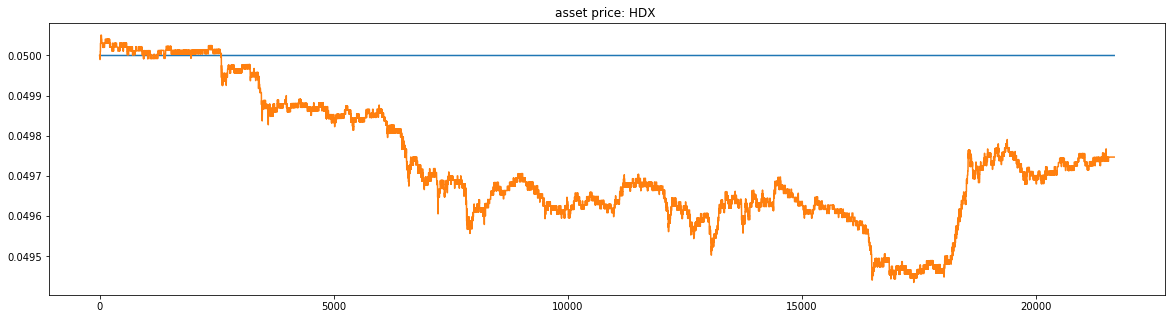

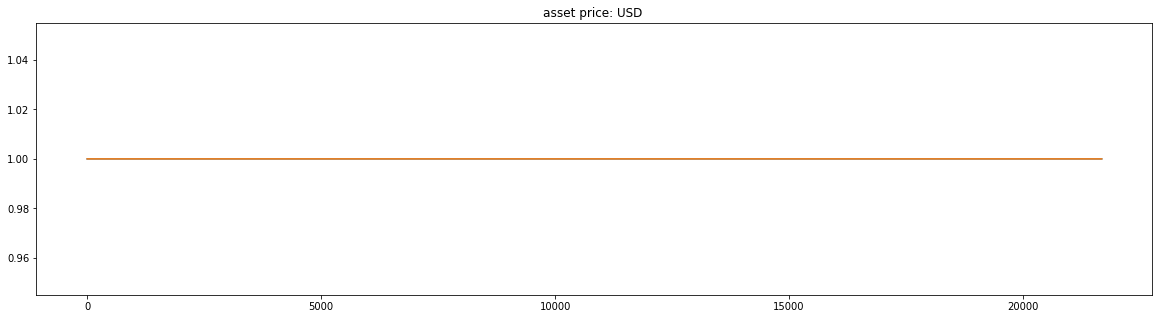

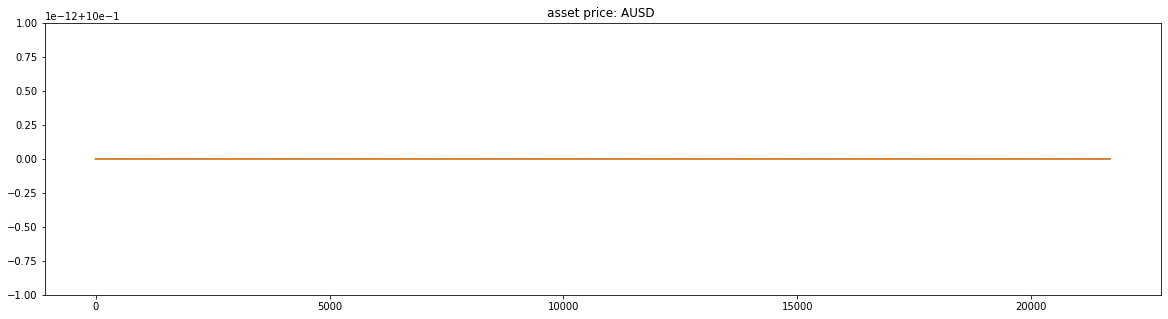

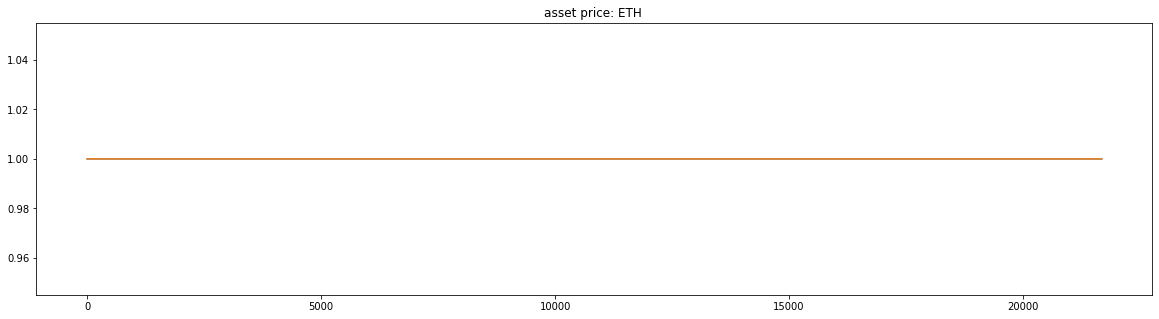

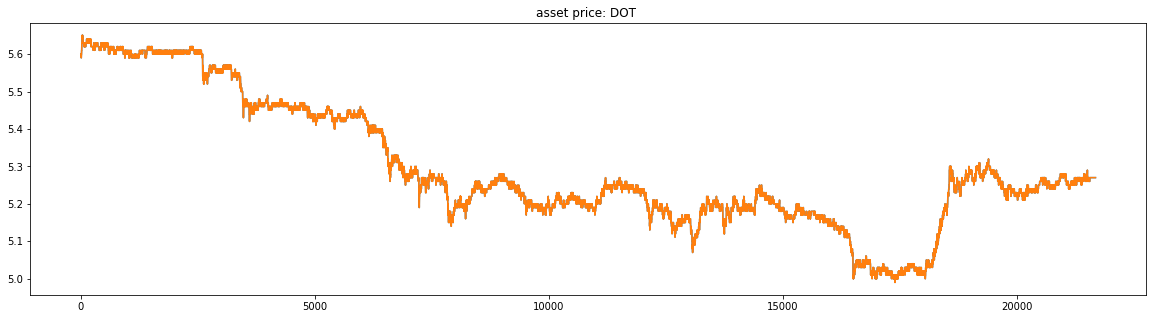

In [125]:
for tkn in initial_state.pools['omnipool'].asset_list:
    ax = pu.plot(events, asset=tkn)
    pu.plot(events, pool='omnipool', prop='usd_price', key=tkn, subplot=ax)

:::FEES:::


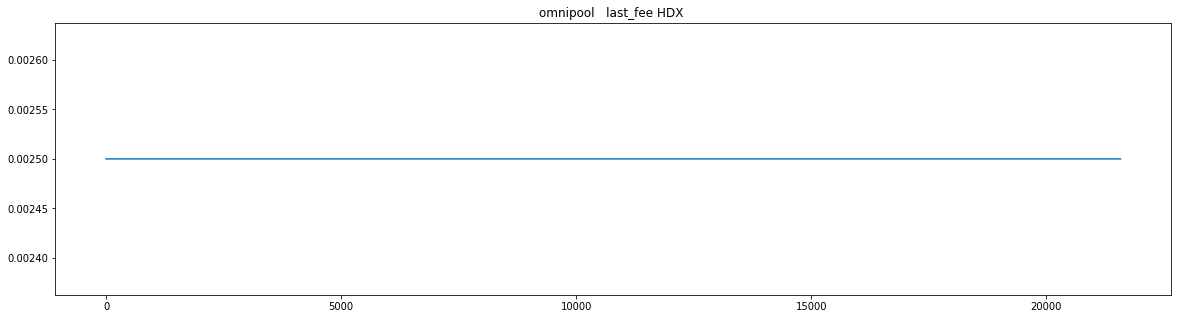

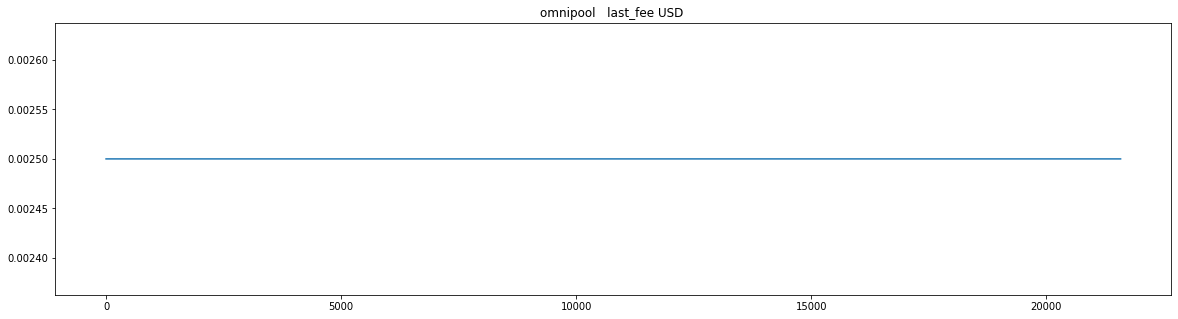

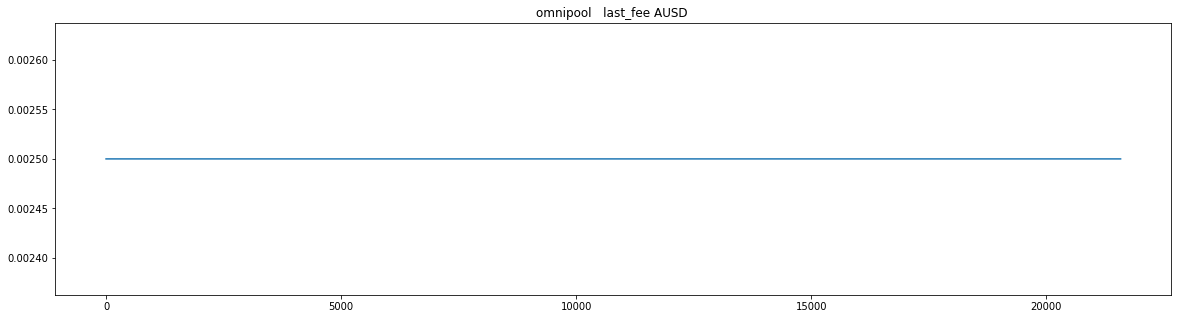

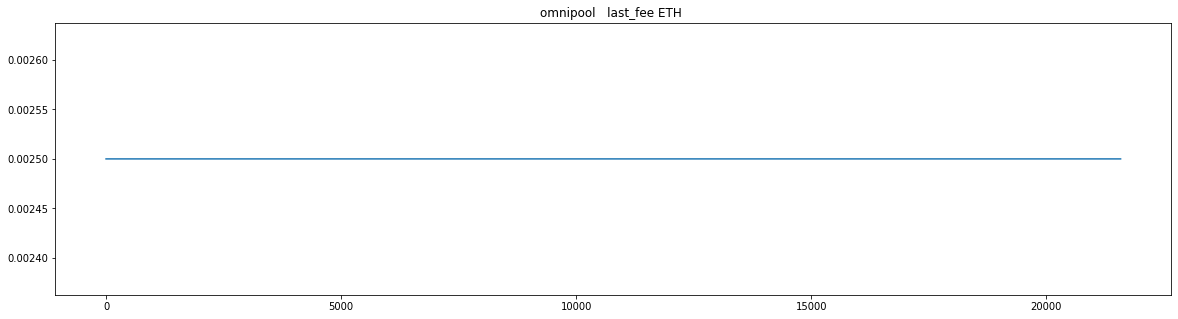

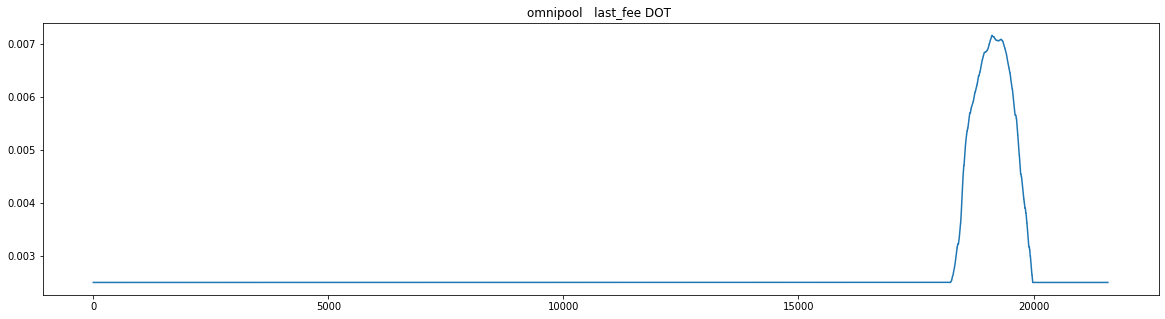

In [126]:
# print(events[0])
# dynamic_mult = [events[i]['state'].pools['omnipool'].last_mult for i in range(len(events))]
# plt.plot(range(len(dynamic_mult)), dynamic_mult)
# print(initial_state.pools['omnipool'].asset_list)
print(":::FEES:::")
# asset_fee = pu.get_datastream(events, pool='omnipool', prop='asset_fee', key='all')  # {tkn: [event['asset_fee'][tkn] for event in events[10:]] for tkn in assets}
# lrna_fee = pu.get_datastream(events, pool='omnipool', prop='lrna_fee', key='all')  # {tkn: [event['lrna_fee'][tkn] for event in events[10:]] for tkn in assets}
# print(lrna_fee['HDX'][1])
for tkn in initial_state.pools['omnipool'].asset_list:
    # print(tkn)
    # plt.figure(figsize=(20, 5))
    # ax = pu.plot(events[10:], pool='omnipool', prop='last_lrna_fee', key=tkn)
    pu.plot(events[100:], pool='omnipool', prop='last_fee', key=tkn)
    # plt.title(tkn)

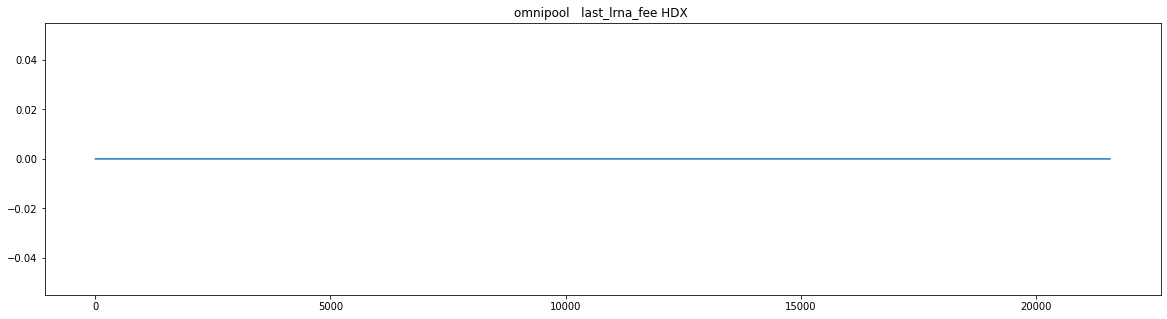

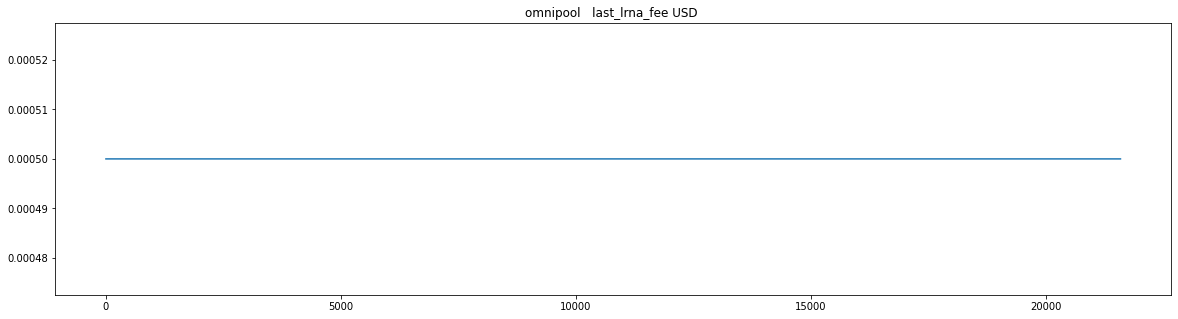

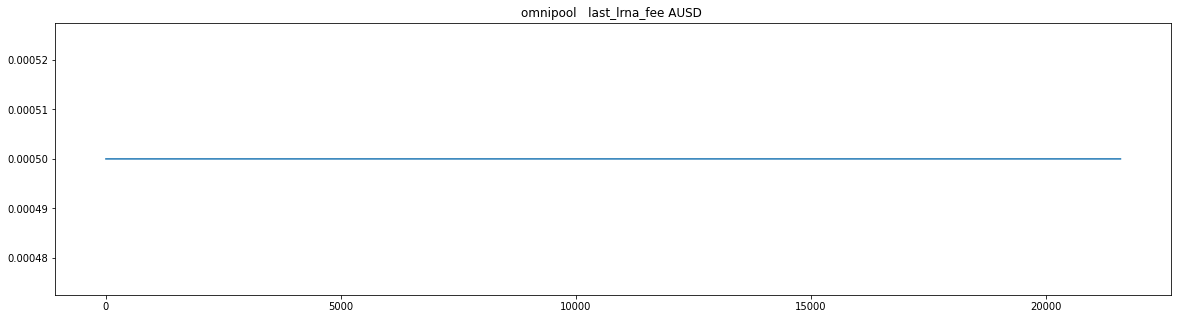

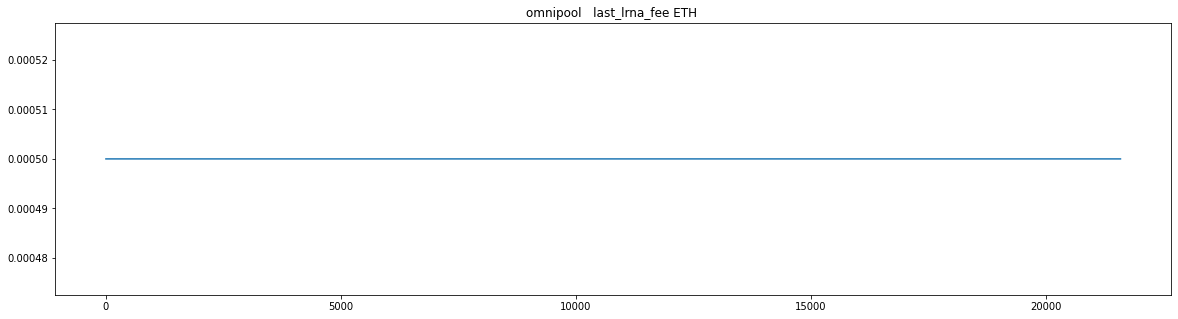

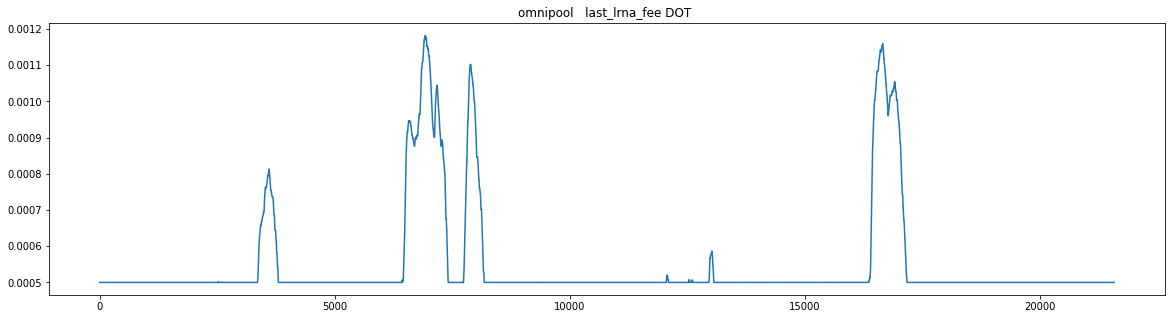

In [127]:
for tkn in initial_state.pools['omnipool'].asset_list:
    pu.plot(events[100:], pool='omnipool', prop='last_lrna_fee', key=tkn)

In [128]:
basic_state = initial_state.copy()
basic_state.pools['omnipool'].lrna_fee = 0.0005
basic_state.pools['omnipool'].asset_fee = 0.0025

events2 = run.run(basic_state, time_steps=time_steps)
# events2 = processing.postprocessing(events2, optional_params=['withdraw_val'])

# print(events2[-1])
# feeless_arbitrageur = events2[-1]['state'].agents['Arbitrageur']

Starting simulation...
Execution time: 65.087 seconds.


<AxesSubplot:>

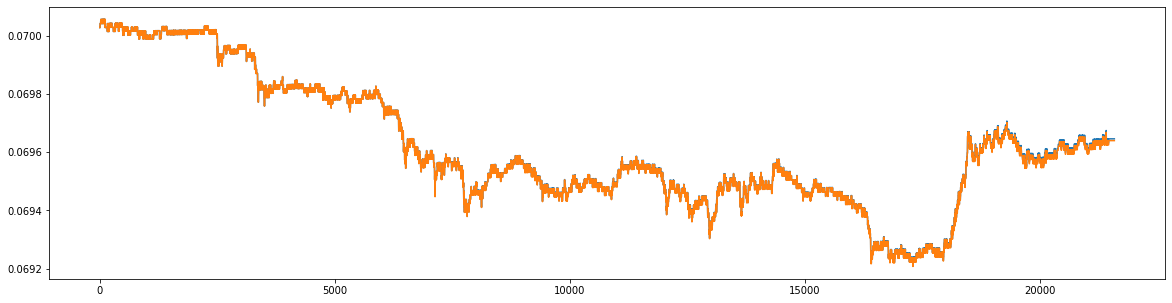

In [129]:
# for tkn in initial_state.pools['omnipool'].asset_list:
#     # print(tkn)
#     # plt.figure(figsize=(20, 5))
#     ax = pu.plot(events[100:], pool='omnipool', prop='price', key=tkn)
#     pu.plot(events2[100:], pool='omnipool', prop='price', key=tkn, subplot=ax)
#     # plt.title(tkn)

lrna_prices = [1/event['state'].pools['omnipool'].price("USD") for event in events[100:]]
lrna_prices2 = [1/event['state'].pools['omnipool'].price("USD") for event in events2[100:]]
ax = pu.plot(lrna_prices)
pu.plot(lrna_prices2, subplot=ax)

Text(0.5, 1.0, 'LPETH with dynamic fees (blue) vs 0.25% flat (orange)')

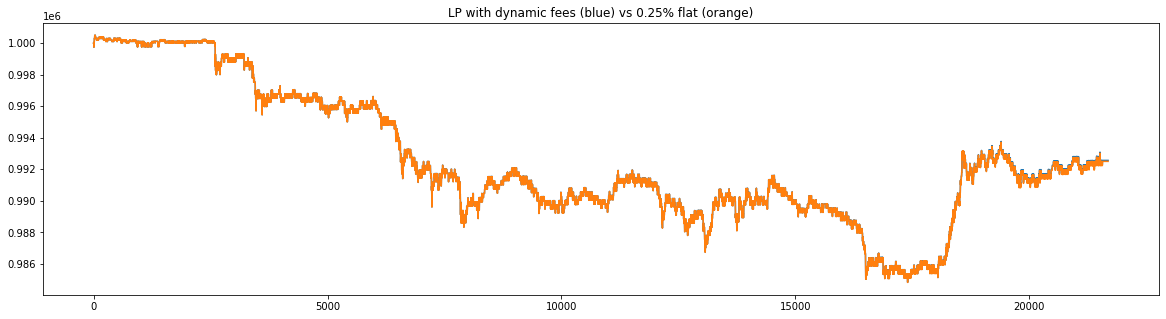

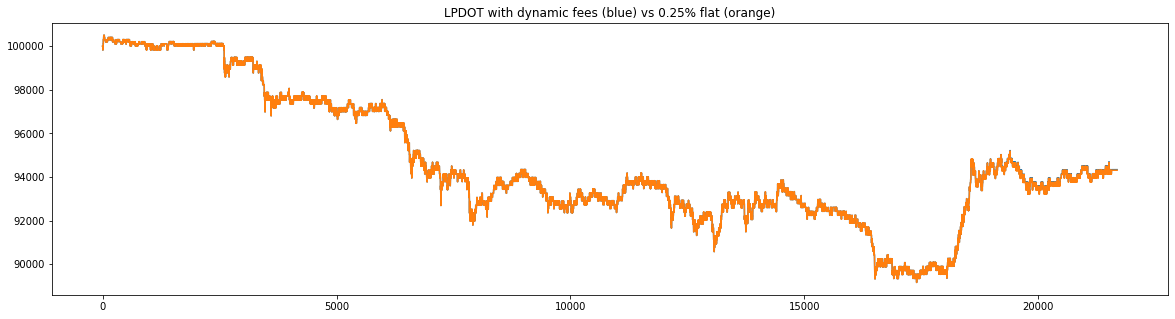

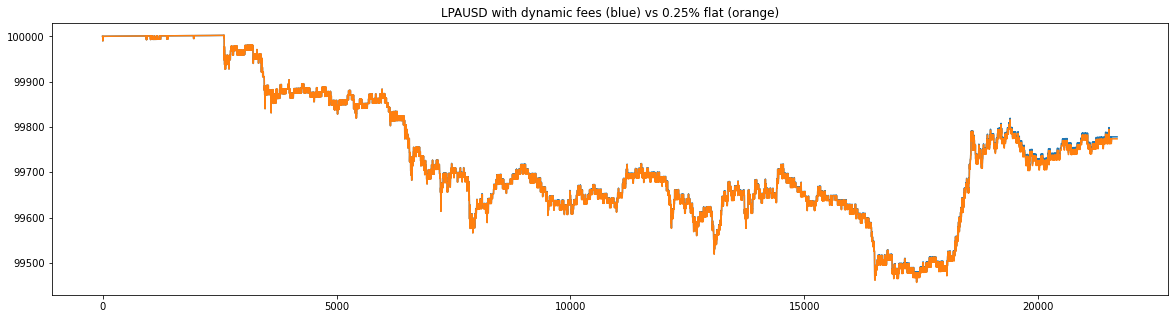

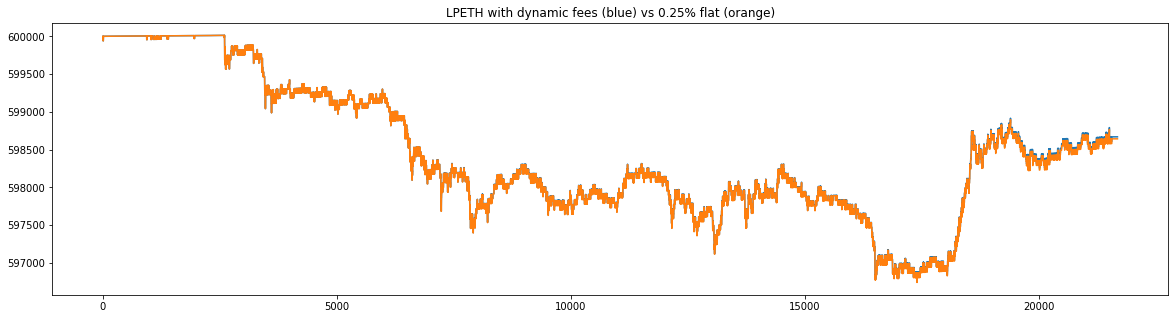

In [130]:
# lp_with_fees = pu.get_datastream(events, 'LP returns')
# lp_no_fees = pu.get_datastream(events2, 'LP returns')
# import cProfile, pstats
# profiler = cProfile.Profile()
# profiler.enable()

ax = pu.plot(events, agent='LP', prop='cash_out')
pu.plot(events2, agent='LP', prop='cash_out', subplot=ax)
plt.title('LP with dynamic fees (blue) vs 0.25% flat (orange)')





ax = pu.plot(events, agent='LPDOT', prop='cash_out')
pu.plot(events2, agent='LPDOT', prop='cash_out', subplot=ax)
plt.title('LPDOT with dynamic fees (blue) vs 0.25% flat (orange)')

# lp_cashout = state.cash_out(state.agents['LPDOT'])

ax = pu.plot(events, agent='LPAUSD', prop='cash_out')
pu.plot(events2, agent='LPAUSD', prop='cash_out', subplot=ax)
plt.title('LPAUSD with dynamic fees (blue) vs 0.25% flat (orange)')

ax = pu.plot(events, agent='LPETH', prop='cash_out')
pu.plot(events2, agent='LPETH', prop='cash_out', subplot=ax)
plt.title('LPETH with dynamic fees (blue) vs 0.25% flat (orange)')

# profiler.disable()
# stats = pstats.Stats(profiler)
# stats.dump_stats('profile-data')



In [131]:
# lp_cashout = state.cash_out(state.agents['LPDOT'])


# lrna_imbalance = [event['state'].pools['omnipool'].lrna_imbalance for event in events]
pprint(events[0]['state'].cash_out(events[0]['state'].agents['LPAUSD']))
pprint(events[-1]['state'].cash_out(events[-1]['state'].agents['LPAUSD']))
pprint(events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPAUSD']))
savings = events[-1]['state'].cash_out(events[-1]['state'].agents['LPAUSD']) - events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPAUSD'])
pprint(savings/events[0]['state'].cash_out(events[0]['state'].agents['LPAUSD']))

pprint(events[0]['state'].cash_out(events[0]['state'].agents['LPETH']))
pprint(events[-1]['state'].cash_out(events[-1]['state'].agents['LPETH']))
pprint(events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPETH']))
savings = events[-1]['state'].cash_out(events[-1]['state'].agents['LPETH']) - events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPETH'])
pprint(savings/events[0]['state'].cash_out(events[0]['state'].agents['LPETH']))

mpf('100000.0')
mpf('99778.214150885849905093616013302011505765280036824267')
mpf('99773.812697108058606483379732653355946240867129590063')
mpf('0.00004401453777791298610236280648655559524412907234204011')
mpf('600000.0')
mpf('598669.28490531508831535202902172988967328368915362673')
mpf('598642.87618264843654931310486097774777648315678865899')
mpf('0.00004401453777775294339820693458690316133422060827957053')


In [132]:
# pprint(events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPDOT']))
init_omni = events[1]['state'].pools['omnipool']
final_omni = events[-1]['state'].pools['omnipool']
init_omni2 = events2[1]['state'].pools['omnipool']
final_omni2 = events2[-1]['state'].pools['omnipool']

pprint(events[-1]['state'].cash_out(events[-1]['state'].agents['LPDOT']))
pprint(events[-1]['state'].agents['LPDOT'].holdings[('omnipool', 'DOT')])
pprint(events[-1]['state'].agents['LPDOT'].share_prices[('omnipool', 'DOT')])
print(events[0]['state'].pools['omnipool'].price('DOT'))
print(events[-1]['state'].pools['omnipool'].price('DOT'))
print(events2[-1]['state'].pools['omnipool'].price('DOT'))
print(events[0]['state'].pools['omnipool'].price('USD'))
print(events[-1]['state'].pools['omnipool'].price('USD'))
print(events2[-1]['state'].pools['omnipool'].price('USD'))
print(events[0]['state'].pools['omnipool'].price('DOT')/events[0]['state'].pools['omnipool'].price('USD'))
print(events[-1]['state'].pools['omnipool'].price('DOT')/events[-1]['state'].pools['omnipool'].price('USD'))
print(events2[-1]['state'].pools['omnipool'].price('DOT')/events2[-1]['state'].pools['omnipool'].price('USD'))
print(init_omni.liquidity['DOT'])
print(final_omni.liquidity['DOT'])
print(final_omni2.liquidity['DOT'])
print(init_omni.lrna['DOT'])
print(final_omni.lrna['DOT'])
print(final_omni2.lrna['DOT'])
print(init_omni.lrna_total)
print(final_omni.lrna_total)
print(final_omni2.lrna_total)
pprint(init_omni.lrna)
pprint(final_omni.lrna)
pprint(final_omni2.lrna)

pprint(events[0]['state'].agents['Arbitrageur'].holdings['LRNA'])
pprint(events[-1]['state'].agents['Arbitrageur'].holdings['LRNA'])
pprint(events2[-1]['state'].agents['Arbitrageur'].holdings['LRNA'])


# pprint(events2[0]['state'].agents['LPDOT'])
# pprint(events2[-1]['state'].agents['LPDOT'])
# pprint(events[0]['state'].agents['LPDOT'])
# pprint(events[-1]['state'].agents['LPDOT'])
# state.cash_out(state.agents['LPDOT'])


mpf('94336.687478410409090326547571011060057018814917645033')
mpf('17857.14285714285870199091732501983642578125')
mpf('79.99999999999998435378074645996166608385991025894582')
79.999999999999984353780746459961666083859910258946
75.668408698183100474228545984015703957907389863168
75.675085105481132343301421806112365607873047972089
14.285714285714279858394525479292829015699495474455
14.358331821287152892070905060647833185006357604856
14.359598691742147984320182495327160338474717242963
5.6000000000000012002739982643150196588911327540825
5.2699999999999864004406950541635910823897298456335
5.2700000000000008681255185233407876241811520443855
214285.71428571432655750694179189820540832896549534
220956.68350204274694986233511501449418437328866947
220883.91910930189430694417164652410198705643855517
17142857.142857138066307519035616189008566691257001
16719440.63182766176760196685791015625
16715409.37702863104641437530517578125
168571428.5714285552501678466796875
168535353.5409308748281895399589933

In [133]:
# print(events[0], events[1000])

In [134]:
print(processing.cash_out(events[0]['state'], events[-1]['state'].agents['LP']))
print(processing.cash_out(events[-1]['state'], events[-1]['state'].agents['LP']))
print(processing.cash_out(events2[-1]['state'], events2[-1]['state'].agents['LP']))

1000000.0000000000079381326908592844297661921881755
992562.40068549718996341761319756965291102961834439
992500.39854084502607665229951865028738125640772844


In [135]:
print(processing.cash_out(events[0]['state'], events[-1]['state'].agents['LPDOT']))
print(processing.cash_out(events[-1]['state'], events[-1]['state'].agents['LPDOT']))
print(processing.cash_out(events2[-1]['state'], events2[-1]['state'].agents['LPDOT']))

100000.00000000000238701756773350172764803384772142
94336.687478410409090326547571011060057018814917645
94309.896963980461822528021393145535339954766948364


In [136]:
print(processing.cash_out(events[0]['state'], events[-1]['state'].agents['LPAUSD']))
print(processing.cash_out(events[-1]['state'], events[-1]['state'].agents['LPAUSD']))
print(processing.cash_out(events2[-1]['state'], events2[-1]['state'].agents['LPAUSD']))

100000.0
99778.214150885849905093616013302011505765280036824
99773.81269710805860648337973265335594624086712959


In [137]:
print(events[-1]['state'].agents['LPDOT'].holdings[('omnipool', 'DOT')])
print(events2[-1]['state'].agents['LPDOT'].holdings[('omnipool', 'DOT')])
print(events[0]['state'].pools['omnipool'].price('DOT')/events[0]['state'].pools['omnipool'].price('USD'))
print(events[-1]['state'].pools['omnipool'].price('DOT')/events[-1]['state'].pools['omnipool'].price('USD'))
print(events2[-1]['state'].pools['omnipool'].price('DOT')/events2[-1]['state'].pools['omnipool'].price('USD'))
# print(events[-1]['state'].agents['LPAUSD'])

17857.14285714285870199091732501983642578125
17857.14285714285870199091732501983642578125
5.6000000000000012002739982643150196588911327540825
5.2699999999999864004406950541635910823897298456335
5.2700000000000008681255185233407876241811520443855


<AxesSubplot:title={'center':'omnipool   price USD '}>

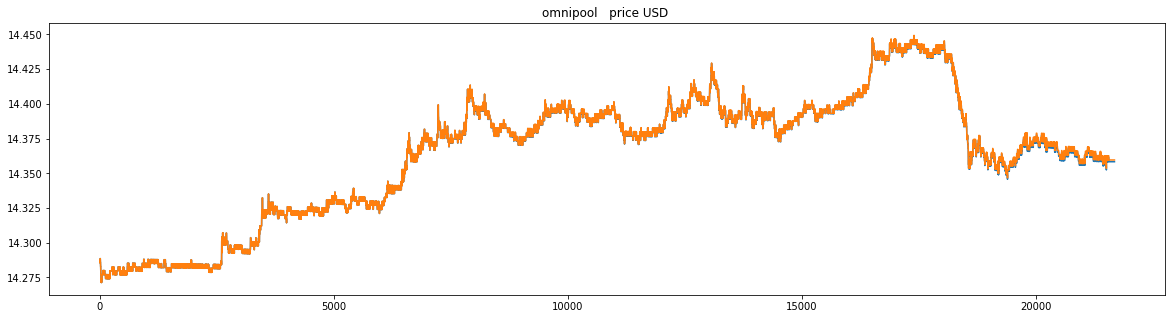

In [138]:
ax = pu.plot(events, pool='omnipool', prop='price', key='USD')
pu.plot(events2, pool='omnipool', prop='price', key='USD', subplot=ax)

In [139]:
final_pool1 = events[-1]['state'].pools['omnipool']
final_pool2 = events2[-1]['state'].pools['omnipool']
lrna_price1 = 1/events[-1]['state'].pools['omnipool'].price('USD')
print(lrna_price1)
lrna_price2 = 1/events2[-1]['state'].pools['omnipool'].price('USD')
print(lrna_price2)
total_lrna1 = sum(events[-1]['state'].pools['omnipool'].lrna[tkn] for tkn in events[-1]['state'].pools['omnipool'].asset_list)
print(total_lrna1)
total_lrna2 = sum(events2[-1]['state'].pools['omnipool'].lrna[tkn] for tkn in events2[-1]['state'].pools['omnipool'].asset_list)
print(total_lrna2)
print(lrna_price1*total_lrna1)
print(lrna_price2*total_lrna2)
print(final_pool1.lrna_imbalance) # dynamic fees cause us to burn a lot more LRNA!
print(final_pool2.lrna_imbalance)

0.069645973672055378336208405594801243599679846313786
0.069639829180955830177451566021584323100653325820811
168535353.54093087482818953995899334993925059957473
168537326.56748867891030809183216378816660514573031
11737808.795522216890127408393748587807733624093171
11736910.632774880403657939292818514092178368669309
0.0
0.0


In [140]:
print(initial_state)

global state 
pools: 

    Omnipool: omnipool
    ********************************
    tvl cap: inf
    lrna fee: Dynamic LRNA fee (oracle=fee_raise, amplification=1, min=0.0005)
    asset fee: Dynamic fee (oracle=fee_raise, amplification=1, min=0.0025)
    asset pools: (
    
        *HDX*
        asset quantity: 20000000.0
        lrna quantity: 14285714.285714284
        USD price: 0.05
        tvl: $1000000.0
        weight: 14285714.285714284/142857142.85714284 (0.1)
        weight cap: 1.0
        total shares: 20000000.0
        protocol shares: 20000000.0
    
        *USD*
        asset quantity: 1000000.0
        lrna quantity: 14285714.285714284
        USD price: 1.0
        tvl: $1000000.0
        weight: 14285714.285714284/142857142.85714284 (0.1)
        weight cap: 1.0
        total shares: 1000000.0
        protocol shares: 1000000.0
    
        *AUSD*
        asset quantity: 1000000.0
        lrna quantity: 14285714.285714284
        USD price: 1.0
        tvl: $1000